In [31]:
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, clear_output

%matplotlib inline

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [217]:
from mnist import train_images, test_images

# Loading dataset
# X = np.vstack([train_images(), test_images()]) / 255
X = train_images() / 255

In [218]:
X.shape

(60000, 28, 28)

In [219]:
X = X.reshape(X.shape[0], 28*28)
X.shape

(60000, 784)

In [220]:
latent_size = 256

w_hid = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[X.shape[1], latent_size]), dtype="float32")
b_hid = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[latent_size]), dtype="float32")
w_out = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[latent_size, X.shape[1]]), dtype="float32")
b_out = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[X.shape[1]]), dtype="float32")

X_in_clear = tf.placeholder("float32", shape=[None, X.shape[1]])
X_in_noisy = tf.placeholder("float32", shape=[None, X.shape[1]])
X_out = tf.placeholder("float32", shape=[None, X.shape[1]])

In [221]:
learning_rate = 0.05

latent_layer = tf.nn.sigmoid(tf.matmul(X_in_noisy, w_hid) + b_hid)
out_wo_activ = tf.matmul(latent_layer, w_out) + b_out
out_layer = tf.nn.sigmoid(out_wo_activ)

# loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=X_in_clear, labels=out_wo_activ))
loss = tf.losses.mean_squared_error(X_in_clear, out_layer)

# optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, var_list=[w_hid, b_hid, w_out, b_out])
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

def train_epoch(X, y):
    optimizer.run({X_in_noisy: X, X_in_clear: y}, session=s)
    return loss.eval({X_in_noisy: X, X_in_clear: y}, s)


In [222]:
def latent_repr(X):
    return latent_layer.eval({X_in_noisy: X}, s)

In [223]:
def predict(X):
    return out_layer.eval({X_in_noisy: X}, s)

In [235]:
def add_noise(X, ratio=0.3):
    res = X.copy()
#     for i in range(len(res)):
#         indices = np.random.choice(range(res.shape[1]), size=[int(ratio * res.shape[1])], replace=False)
#         res[i][indices] = 0
    res += np.random.normal(size=X.shape, scale=ratio)
    return res

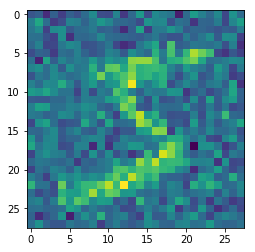

In [236]:
plt.imshow(add_noise(np.array([X[0]]))[0].reshape(28, 28))

In [237]:
batch_size = 100
epochs = 1500

s.run(tf.global_variables_initializer())

losses = []
xs = []

for i in range(epochs):
    out_batch = X[np.random.choice(range(X.shape[0]), size = [batch_size], replace=False)]
    in_batch = add_noise(out_batch, 0.1)
#     in_batch = out_batch

    loss_i = train_epoch(in_batch, out_batch)
    if i % 10 == 0 and i > 0:
        losses.append(loss_i)
        xs.append(i)
    clear_output(True)
    print("Epoch: {}\nLoss: {}".format(i + 1, loss_i))


Epoch: 1500
Loss: 0.008582526817917824


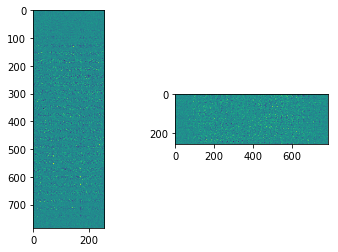

In [238]:
plt.figure(2)
plt.subplot(121)
plt.imshow(w_hid.eval())

plt.subplot(122)
plt.imshow(w_out.eval())
plt.show()

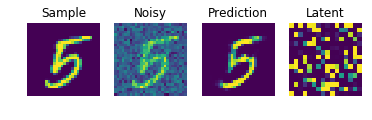

In [249]:
noise_coef = 0.2

X_val = test_images()
X_val = X_val.reshape(X_val.shape[0], 28*28) / 255

num = np.random.randint(0, X_val.shape[0])

source = X_val[num]
noisy = add_noise(np.array([source]), noise_coef)[0]
result = predict([noisy])[0]
latent = latent_repr([noisy])[0]


plt.figure(1)
plt.subplot(141)
plt.axis("off")
plt.title("Sample")
plt.imshow(source.reshape(28, 28))

plt.subplot(142)
plt.axis("off")
plt.title("Noisy")
plt.imshow(noisy.reshape(28, 28))

plt.subplot(143)
plt.axis("off")
plt.title("Prediction")
plt.imshow(result.reshape(28, 28))

plt.subplot(144)
plt.axis("off")
plt.title("Latent")
plt.imshow(latent.reshape(16, 16))

plt.show()